In [1]:
import os
import random
import re
from collections import defaultdict
from datetime import datetime
from typing import Dict, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat

In [2]:
class SeedDatasetLoader:
    fs = 200  # 200Hz

    def __init__(self, *,
                 preprocessed_eeg_dir="datasets/SEED/Preprocessed_EEG",
                 channel_order_filepath="datasets/SEED/channel-order.xlsx"):
        self.preprocessed_eeg_dir = preprocessed_eeg_dir
        self.channel_order_filepath = channel_order_filepath

        # Initialize data structures
        self.experiment_dates: Dict[int, Dict[int, datetime]] = defaultdict(dict)
        self.subjects_data: Dict[int, Dict[int, Dict[str, np.ndarray]]] = defaultdict(dict)
        """
        Subject No: {
          Experiment Date Repetition No (repeated 3 times): {
            djc_eeg1...djc_eeg15: EEG of shape (62, X)
              // 62 channels
              // X length frames with frequency 200Hz
          }
        }
        """
        self.experiment_prefixes: Dict[int, Dict[int, Dict[int, str]]] = defaultdict(lambda: defaultdict(dict))

        self.labels = None
        self.channel_order: Optional[Dict[int, str]] = None

        self.file_pattern = re.compile(r"(\d+)_(\d+)\.mat")
        self._load_channel_order()
        self._load_eeg_data()

    def _load_eeg_data(self):
        _initial_subjects_data = defaultdict(list)

        # Load all files in the preprocessed_eeg_dir
        for filename in os.listdir(self.preprocessed_eeg_dir):
            if filename == "label.mat":
                self.labels = self._load_mat_file(filename)["label"]
            else:
                self._process_file(filename, _initial_subjects_data)

        # Convert lists to dicts, making experiment_rep start from 1, and handle keys
        for subject, data_list in _initial_subjects_data.items():
            sorted_data = sorted(data_list, key=lambda x: x[0])  # Sort by datetime
            self.experiment_dates[subject] = {i + 1: d[0] for i, d in enumerate(sorted_data)}

            formatted_data = defaultdict(dict)
            for i, (_, data_dict) in enumerate(sorted_data):
                for key, value in data_dict.items():
                    if "_eeg" in key:
                        prefix, num = key.split('_eeg')
                        self.experiment_prefixes[subject][i + 1][int(num)] = prefix
                        formatted_data[i + 1][int(num)] = value
            self.subjects_data[subject] = dict(formatted_data)

        self.subjects_data = dict(self.subjects_data)
        self.experiment_dates = dict(self.experiment_dates)

    def _process_file(self, filename, _initial_subjects_data: Dict[int, list]):
        match = self.file_pattern.match(filename)
        if match:
            subject_number = int(match.group(1))
            date_str = match.group(2)
            date_obj = datetime.strptime(date_str, "%Y%m%d")
            data: Dict[str, np.ndarray] = self._load_mat_file(filename)
            # Append to list, to be converted to dict later
            _initial_subjects_data[subject_number].append((date_obj, data))

    def _load_mat_file(self, filename):
        file_path = os.path.join(self.preprocessed_eeg_dir, filename)
        return loadmat(file_path)

    def _load_channel_order(self):
        self.channel_order = pd.read_excel(self.channel_order_filepath, header=None, index_col=None)[0].to_dict()
        return

    def plot_random_eeg(self):
        # Select a random EEG
        random_eeg = self.get_subject_data(
            subject_no=random.randint(1, 15),
            experiment_rep=random.randint(1, 3),
            experiment_no=random.randint(1, 15),
        )
        random_channel = random.randint(0, 61)

        # Create a time array based on the number of samples and the sampling rate
        time = np.linspace(0, random_eeg.shape[1] / self.fs, random_eeg.shape[1])

        # Plotting
        plt.figure(figsize=(15, 5), dpi=150)
        plt.plot(time, random_eeg[random_channel, :])
        plt.title(f"EEG Channel {random_channel + 1}")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.show()

    def get_subject_data(self, subject_no: int, experiment_rep: int, experiment_no: int):
        data = self.subjects_data[subject_no]
        data = data[experiment_rep]
        data = data[experiment_no]
        return data

    def get_labels(self) -> np.ndarray:
        return self.labels

    def get_channel_order(self) -> Dict[int, str]:
        return self.channel_order

In [3]:
loader = SeedDatasetLoader()

In [4]:
loader.get_labels()

array([[ 1,  0, -1, -1,  0,  1, -1,  0,  1,  1,  0, -1,  0,  1, -1]],
      dtype=int16)

In [5]:
loader.get_channel_order()

{0: 'FP1',
 1: 'FPZ',
 2: 'FP2',
 3: 'AF3',
 4: 'AF4',
 5: 'F7',
 6: 'F5',
 7: 'F3',
 8: 'F1',
 9: 'FZ',
 10: 'F2',
 11: 'F4',
 12: 'F6',
 13: 'F8',
 14: 'FT7',
 15: 'FC5',
 16: 'FC3',
 17: 'FC1',
 18: 'FCZ',
 19: 'FC2',
 20: 'FC4',
 21: 'FC6',
 22: 'FT8',
 23: 'T7',
 24: 'C5',
 25: 'C3',
 26: 'C1',
 27: 'CZ',
 28: 'C2',
 29: 'C4',
 30: 'C6',
 31: 'T8',
 32: 'TP7',
 33: 'CP5',
 34: 'CP3',
 35: 'CP1',
 36: 'CPZ',
 37: 'CP2',
 38: 'CP4',
 39: 'CP6',
 40: 'TP8',
 41: 'P7',
 42: 'P5',
 43: 'P3',
 44: 'P1',
 45: 'PZ',
 46: 'P2',
 47: 'P4',
 48: 'P6',
 49: 'P8',
 50: 'PO7',
 51: 'PO5',
 52: 'PO3',
 53: 'POZ',
 54: 'PO4',
 55: 'PO6',
 56: 'PO8',
 57: 'CB1',
 58: 'O1',
 59: 'OZ',
 60: 'O2',
 61: 'CB2'}

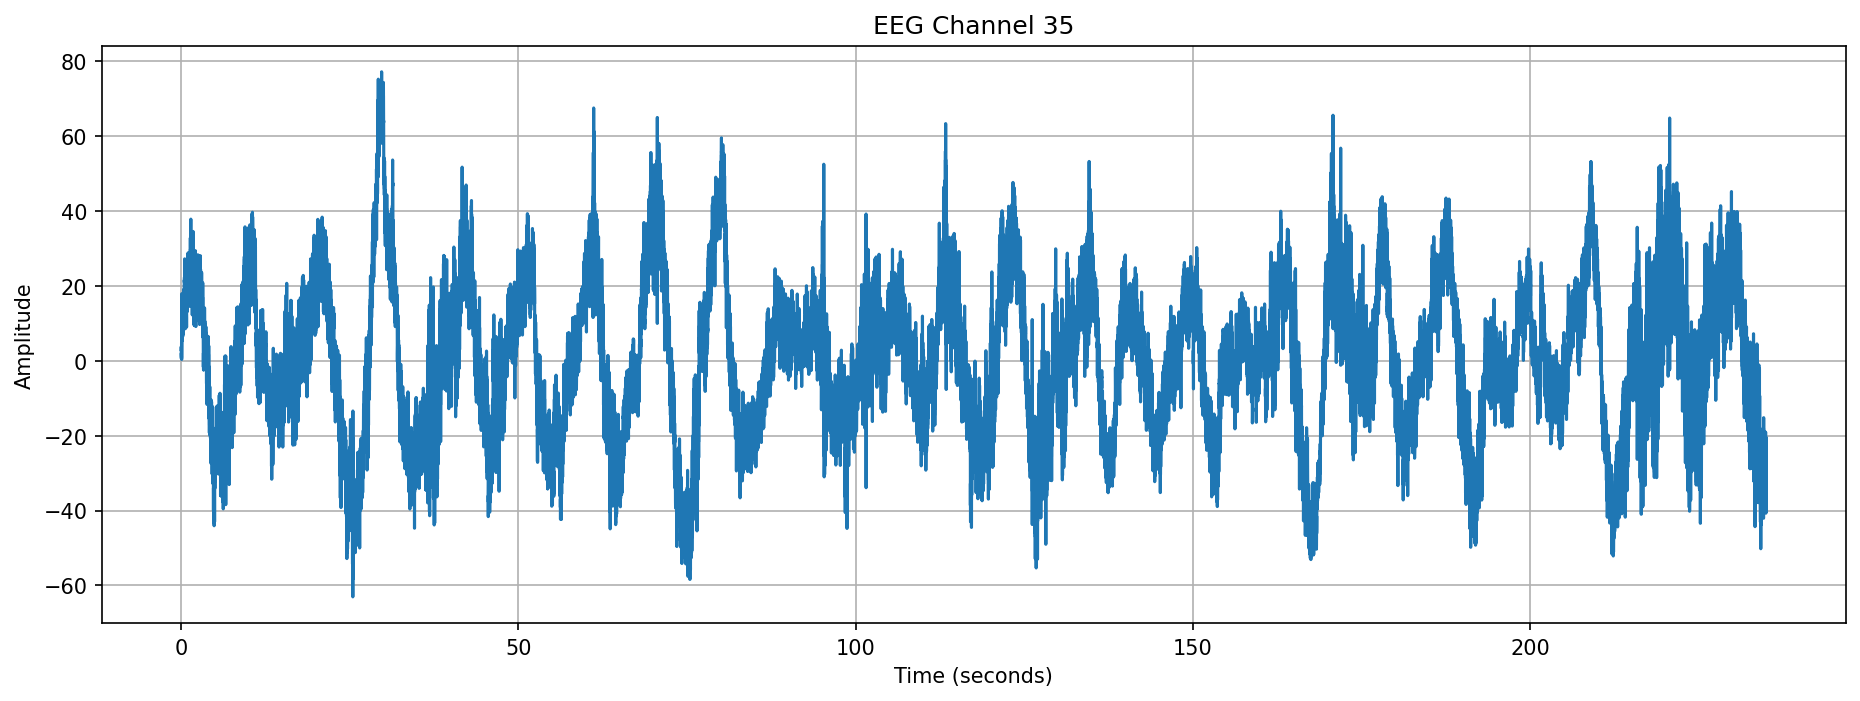

In [6]:
loader.plot_random_eeg()